# 07MIAR - Redes Neuronales y Deep Learning
## VC08: Deep learning para texto y secuencias


### Adrián Colomer Granero

In [10]:
# SOLO PARA USO EN GOOGLE COLABORATORY
# para conectar el notebook con la cuenta de gdrive
from google.colab import drive
drive.mount('/content/drive/')
#!ls "/content/drive/My Drive/"
BASE_FOLDER = '/content/drive/MyDrive/VIU/Docencia/MIAR_04_2021-22/07MAIR/' # Se debe garantizar que la carpeta docencia compartida se almacena en el directorio raíz de Google Drive. En caso contrario modificar este path

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

https://blog.tensorflow.org/2018/11/pushing-limits-of-gpu-performance-with-xla.html

# Deep learning para texto y secuencias
- Redes recurrentes (Long-short Term Memory (LSTM) / Gated Recurrent Unit (GRU)) y 1D conv nets
- Aplicaciones en: clasificación de documentos, comparación de textos, aprendizaje secuencia-a-secuencia (traduccion), analisis de sentimiento, predicción, etc.

### Shallow-learning
- Bag of words, formadas por n-gramas (sets de n o menos palabras consecutivas)
- Pierde el sentido de secuencia
- Útil para métodos clásicos (regresión y random forests)

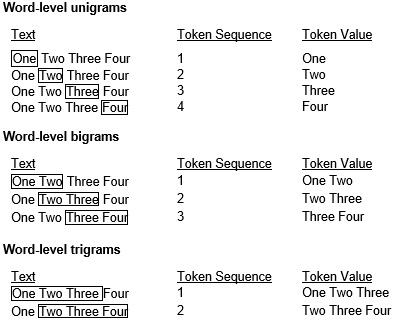

In [11]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/n-grams.jpg")
# source https://www.sqlservercentral.com/articles/nasty-fast-n-grams-part-1-character-level-unigrams

### Deep learning
- Se suele trabajar con secuencias de palabras
- Transformar palabras a vectores
 - One-hot encoding
 - Word embedding 

## One-hot encoding
- Vector de longitud = número de palabras
- Activación positiva (1) que indica el índice de la palabra

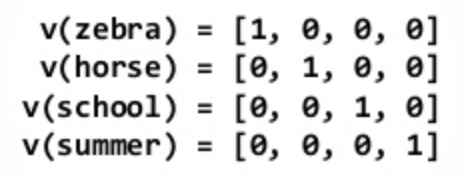

In [12]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/hot_encoding.PNG")

In [ ]:
# Keras tiene herramientas para Tokenizar texto y codificarlo en one-hot encoding
from tensorflow.keras.preprocessing.text import Tokenizer

samples = ['En un rincon de la mancha','De cuyo nombre no quiero acordarme']

# Construir el indice de palabras
tokenizer = Tokenizer(num_words=1000) # solo considerar las 1000 palabras mas frecuentes -> TAMAÑO VOCABULARIO
tokenizer.fit_on_texts(samples)

In [ ]:
# Convierte las frases en listas de indices (a cada palabra se le asocia un int)
sequences = tokenizer.texts_to_sequences(samples)
print(sequences)

In [ ]:
# Diccionario palabras-indices
word_index = tokenizer.word_index
word_index

In [ ]:
# Convirtiendo a one-hot encoding
from tensorflow.keras.utils import to_categorical
sequences_ohe = to_categorical(sequences, num_classes=None, dtype="int")
print(sequences_ohe)

### One hot encoding alternativas
- One hot encoding da lugar a:
 - Requisitos de memoria (vectores de tamaño del vocabulario, mantener lista de índices y palabras)
 

### Ejercicio
Investigar cómo funciona one-hot encoding mediante hash functions

## Word embedding
- Menos dimensiones y más densos (utilizando valores decimales en vez de solo 1 y 0)

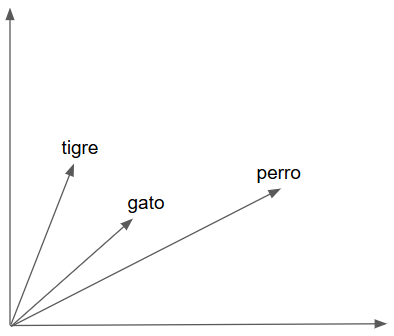

In [ ]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/word_embedding.PNG")

### Propiedades
Debe representar las relaciones semánticas entre palabras
- Distancia entre vectores aproxima distancia entre significados (pato y ganso vs pato y mesa)

No existe un word embedding universal
- Depende del idioma (cultura)
- Depende del dominio (banco en finanzas o arquitectura)

Recurso: https://projector.tensorflow.org/

### Obtener Word embeddings
- Aprenderlos como un problema de ML
- Obtener pre-entrenados (no lo pondremos en práctica): word2vec (https://code.google.com/archive/p/word2vec/), GloVe (http://nlp.stanford.edu/projects/glove)

#### Aprenderlos
- Utilizando la capa Embedding de Keras:
 - Input: índice de palabras (secuencia)
 - Output: tensor codificando la secuencia

## **ENTRENANDO NUESTRO PRIMER MLP PARA CLASIFICACIÓN DE TEXTO: REVIEWS IMDB**

#### **- Cargando el conjunto de datos**

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
import numpy as np

# Considerar las 5000 palabras mas frecuentes en nuestro diccionario
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# Reducir las secuencias a 500 palabras
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

# Mostrar aleatoriamente una review
rev_idx = np.random.randint(0, X_train.shape[0])
print(X_train[rev_idx])

# Mostrar por pantalla las dimensiones de los subconjuntos de datos de train y test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#### **- Inspeccionando el conjunto de datos**

In [ ]:
import numpy as np
# Obtain 3 texts
for i in np.random.randint(0, len(X_train), 3):
  INDEX_FROM=3   # word index offset
  word_to_id = imdb.get_word_index()
  word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
  word_to_id["<PAD>"] = 0
  word_to_id["<START>"] = 1
  word_to_id["<UNK>"] = 2
  word_to_id["<UNUSED>"] = 3

  id_to_word = {value:key for key,value in word_to_id.items()}
  print('=================================================')
  print(f'Sample = {i} | Length = {len(X_train[i])}')
  print('=================================================')
  print(' '.join(id_to_word[id] for id in X_train[i] ))

#### **- Creando la topología de red neuronal y entrenándola: EMBEDDING**

In [ ]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout

# Establecemos semilla para garantizar reproducibilidad de resultados
numpy.random.seed(42)

# Creamos la arquitectura MLP
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# Compilamos el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
H = model.fit(X_train, y_train, epochs=20, validation_split=0.05, batch_size=64)

# Evaluamos el modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

~52% accuracy con un modelo simple (no considera el orden de las palabras por el uso de flatten y dense)

## Utilizando redes recurrentes: LSTM
- Redes en las que el output tiene conexiones con partes iniciales de la red
- Proporciona memoria a la red, analizar secuencias de inputs

#### Long Short-term Memory
- Propuesto por *Hochreiter and Schmidhuber (1997), "Long Short-Term Memory". Neural Computation 9, no. 8.*
- Como red recurrente, el output de la inferencia anterior influye al de la siguiente
- Elemento (carry) que no entra en la red y modula el elemento recurrente antes de entrar

El output de cada unidad de una celula de LSTM depende de
- Input
- Output anterior
- Memoria (computado a partir del output)

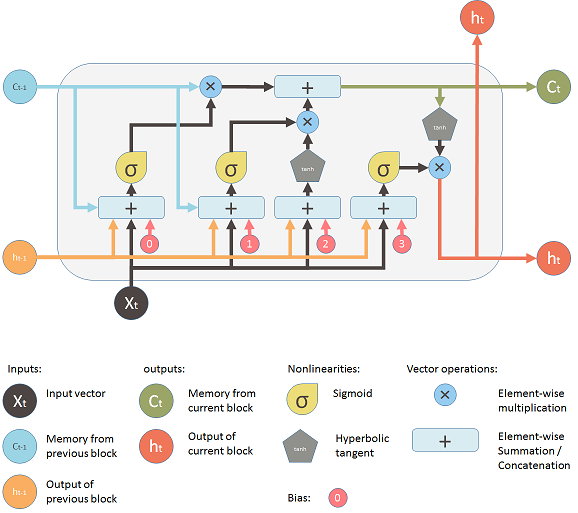

In [ ]:
from IPython.display import Image
Image(filename=BASE_FOLDER+"img/lstm.png")
#Imagen de: https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714 (accedido el 15/02/2019)

#### **- Creando la topología de red neuronal y entrenándola: RNN (unidades LSTM)**

In [ ]:
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# Establecemos semilla para garantizar reproducibilidad de resultados
numpy.random.seed(42)

# Creamos la arquitectura LSTM
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# Compilamos el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=3, validation_split=0.05, batch_size=64)

# Evaluamos el modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
372/372 [==============================] - 109s 288ms/step - loss: 0.5314 - accuracy: 0.7046 - val_

**EJERCICIO PROPUESTO:** Entrenar el modelo por 10 épocas empleando la técnica de EarlyStopping para paliar el efecto de overfitting. Pista: Uso de callbacks cuando se llama a la función train

## Mejorando LSTM
- LSTM bidireccional -> Se tienen en cuenta ambos tipos de secuencia lógica
- Concatenar capas recurrentes para más expresividad
- Dropout recurrente (dentro de la misma capa LSTM) https://arxiv.org/pdf/1512.05287.pdf


#### **- Creando la topología de red neuronal y entrenándola: LSTM bidireccional con capas concatenadas**

In [ ]:
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# Establecemos semilla para garantizar reproducibilidad de resultados
numpy.random.seed(42)

# Creamos la arquitectura LSTM
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# Compilamos el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=3, validation_split=0.05, batch_size=64)

# Evaluamos el modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

#### **- Empleando dropout recurrente en las unidades LSTM**

In [ ]:
import numpy
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

# Establecemos semilla para garantizar reproducibilidad de resultados
numpy.random.seed(42)

# Creamos la arquitectura LSTM
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(100, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

# Compilamos el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamos el modelo
model.fit(X_train, y_train, epochs=3, validation_split=0.05, batch_size=64)

# Evaluamos el modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

## **Uso de LSTM para generar secuencias de texto: DON QUIJOTE DE LA MANCHA**

- Modelos de lenguaje, dada una serie de palabras, predecir (probabilistico) la proxima palabra o secuencia
- Sampling estocástico (elegir random en base a la probabilidad), cuyas ventajas son:
 - Produce frases más interesantes (creatividad)
 - Parámetro que controla esta estocasticidad es temperatura


In [ ]:
# Cargamos texto del Quijote
with open(BASE_FOLDER+"resources/quijote.txt",'r') as f:
    replace_chars = {'\n': ' ',
                    '\xad':'',
                    '±':'',
                    '³':'',
                    'º':'',
                    '¼':'',
                    'â':'a',
                    'ã':'a',
                    '©':''
    }
    corpus = f.read().lower()
    for old, new in replace_chars.items():
        corpus = corpus.replace(old,new)

# Vectorizar el texto

maxlen = 60 #longitud de las secuencias
step = 3 # cada cuantas letras empezar una secuencia

sentences = []
next_chars = []

for i in range(0,len(corpus) - maxlen,step):
    sentences.append(corpus[i: i + maxlen])
    next_chars.append(corpus[i + maxlen])

In [ ]:
# Vamos a crear nuestro corpus de letras
unique_chars = sorted(list(set(corpus)))
char_indices = {char : i for i,char in enumerate(unique_chars) }
print(char_indices)

{' ': 0, '!': 1, '"': 2, '(': 3, ')': 4, ',': 5, '-': 6, '.': 7, ':': 8, ';': 9, '?': 10, 'a': 11, 'b': 12, 'c': 13, 'd': 14, 'e': 15, 'f': 16, 'g': 17, 'h': 18, 'i': 19, 'j': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'o': 25, 'p': 26, 'q': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'x': 33, 'y': 34, 'z': 35, '¡': 36, '¿': 37, 'á': 38, 'é': 39, 'í': 40, 'ñ': 41, 'ó': 42, 'ú': 43, 'ü': 44}


In [ ]:
import numpy as np

# Vectorizacion (one hot encoding)
x = np.zeros((len(sentences), maxlen,len(unique_chars)), dtype=np.bool) # cada secuencia, hot encoded
y = np.zeros((len(sentences), len(unique_chars)), dtype=np.bool) # para cada secuencia, el siguiente caracter hot encoded
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i,t,char_indices[char]] = 1
    y[i,char_indices[next_chars[i]]] = 1
print(x.shape)
print(y.shape)

(103718, 60, 45)
(103718, 45)


In [ ]:
# Modelo con LSTM
from tensorflow.keras import layers
from tensorflow.keras import models

# Cuando se concatenan LSTM, parametro return_sequences=True excepto en la ultima
# Las capas intermedias pasan toda la secuencia de outputs, pero la ultima solo pasa el ultimo output
model = models.Sequential()
model.add(LSTM(256, input_shape=(maxlen,len(unique_chars)),return_sequences=True)) # devuelve una secuencia de vectores de 128 dimensiones
model.add(LSTM(64))  
model.add(layers.Dense(len(unique_chars), activation='softmax')) # softmax para que el output sume 1

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 256)           309248    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dense_4 (Dense)              (None, 45)                2925      
Total params: 394,349
Trainable params: 394,349
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Entrenar el modelo
history = model.fit(x,y,batch_size=128,epochs=30)

Epoch 1/30
811/811 [==============================] - 11s 13ms/step - loss: 2.4702 - acc: 0.2802
Epoch 2/30
811/811 [==============================] - 11s 13ms/step - loss: 2.0525 - acc: 0.3787
Epoch 3/30
811/811 [==============================] - 11s 13ms/step - loss: 1.9188 - acc: 0.4170
Epoch 4/30
811/811 [==============================] - 11s 13ms/step - loss: 1.8234 - acc: 0.4461
Epoch 5/30
811/811 [==============================] - 11s 13ms/step - loss: 1.7406 - acc: 0.4737
Epoch 6/30
811/811 [==============================] - 11s 13ms/step - loss: 1.6682 - acc: 0.4933
Epoch 7/30
811/811 [==============================] - 11s 13ms/step - loss: 1.6028 - acc: 0.5110
Epoch 8/30
811/811 [==============================] - 11s 13ms/step - loss: 1.5430 - acc: 0.5266
Epoch 9/30
811/811 [==============================] - 11s 13ms/step - loss: 1.4879 - acc: 0.5429
Epoch 10/30
811/811 [==============================] - 11s 13ms/step - loss: 1.4831 - acc: 0.5459
Epoch 11/30
811/811 [========

In [ ]:
import numpy as np

def transform_distribution(predictions, temperature=0.5):
    predictions = np.array(predictions).astype('float64')
    # temperaturas altas: mas entropia (mas aleatorio)
    # temperaturas bajas: menos estocasticidad (mas deterministico)
    predictions = np.log(predictions) / temperature
    exp_predictions = np.exp(predictions)
    predictions = exp_predictions / np.sum(exp_predictions) # asegurarse que los valores suman 1 (probabilidad)
    probs = np.random.multinomial(1, predictions, 1)
    return np.argmax(probs)

In [ ]:
import random
# generar secuencias arbitrarias de texto
predict_length = 400
temperature = 0.8
# random text seed
start_index = random.randint(0,len(corpus) - maxlen - 1)
input_text = corpus[start_index: start_index + maxlen]
print('Seed: ' + input_text)
generated_text = input_text

for i in range(predict_length):
    sampled = np.zeros((1, maxlen, len(unique_chars)))
    for t, char in enumerate(input_text):
        sampled[0,t,char_indices[char]] = 1.
    
    prediction = model.predict(sampled, verbose=0)[0]
    next_index = transform_distribution(prediction,temperature)
    next_char = unique_chars[next_index]
    
    #pegar el nuevo texto
    input_text += next_char
    generated_text += next_char
    input_text = input_text[1:]

generated_text

Seed: pueda vuestra merced decir, señor caballero andante, que le 


'pueda vuestra merced decir, señor caballero andante, que le andejos a todo estorse de las celades. ni sona el reyo de los branos, aunque tras si ella tan se disperia del entrermilos semenenter, suste palteron crierer el camino que ander mus andantes hermosura de hacer dal maricio que se les tal juta de un tiempo, ancisa castilla y estrase había dado a aquel puesto más de él señor traía y sandia, sino fantas las hartas del caspié do llega, entretando lo que'